# Modelo 1: RandonFlorest com limitação

## 1. Instalação de Bibliotecas e Imports

Importa todas as bibliotecas necessárias para:



*   Manipulação de dados (pandas, numpy)

*   Machine Learning (scikit-learn)

* Visualização (matplotlib, seaborn)

* Interpretação de modelos (shap)



In [ ]:
!pip install shap
import pandas as pd
import numpy as np
import shap
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Configurações Iniciais

Define configurações de exibição para DataFrames e estilo de gráficos.

In [ ]:
# Configurações iniciais
pd.set_option('display.max_columns', 50)
plt.style.use('ggplot')

## 3. Carregamento e Preparação dos Dados
Carrega o dataset a partir de um arquivo CSV.

Cria uma variável alvo binária onde 1 representa profissionais que possuem:

* Python E

* Pelo menos uma cloud (AWS/Azure/GCP) E

* Pelo menos uma ferramenta de BI (PowerBI/Tableau)

In [ ]:
# 1. Carregar e preparar os dados
df = pd.read_csv('dados_selecionados.csv')

# Criar variável target
tech_cols = ['python', 'aws', 'azure', 'gcp', 'powerbi', 'tableau']
df[tech_cols] = df[tech_cols].astype(bool)

conditions = (
    df['python'] &
    (df['aws'] | df['azure'] | df['gcp']) &
    (df['powerbi'] | df['tableau'])
)
df['target_ia_generativa'] = np.where(conditions, 1, 0)

## 4. Engenharia de Features

* Adiciona novas features derivadas para capturar:

* Total de linguagens conhecidas

* Experiência total combinada




In [ ]:

# 2. Remover features que causam vazamento
features_seguras = [
    'sql', 'r', 'c_cpp_csharp', 'dotnet', 'java', 'javascript',
    'postgresql', 'bigquery', 'snowflake', 'databricks',
    'looker_studio', 'excel_planilhas', 'exp_dados', 'exp_ti'
]

# 3. Engenharia de features alternativa
df['total_linguagens'] = df[['sql', 'r', 'c_cpp_csharp', 'java', 'javascript']].sum(axis=1)
df['exp_total'] = df['exp_dados'] + df['exp_ti']
features_seguras.extend(['total_linguagens', 'exp_total'])


## 5. Pré-processamento

Transforma variáveis categóricas em numéricas usando mapeamentos customizados.

Cria um pipeline que:

* Aplica One-Hot Encoding para 'nivel_ensino'

* Normaliza features numéricas

In [ ]:
# 4. Pré-processamento Corrigido
# Converter colunas categóricas para numéricas
for col in features_seguras:
    if df[col].dtype == 'object':
        df[col] = df[col].map({'Sim': 1, 'Não': 0}).fillna(0).astype(int)

# Mapeamento de experiência
exp_map = {
    'Menos de 1 ano': 0.5,
    'de 1 a 2 anos': 1.5,
    'de 3 a 4 anos': 3.5,
    'de 5 a 6 anos': 5.5,
    'de 7 a 10 anos': 8.5,
    'Mais de 10 anos': 11
}

df['exp_dados'] = df['exp_dados'].astype(str).map(exp_map).fillna(0)
df['exp_ti'] = df['exp_ti'].astype(str).map(exp_map).fillna(0)

# Definir features numéricas
numeric_features = [
    'sql', 'r', 'c_cpp_csharp', 'dotnet', 'java', 'javascript',
    'postgresql', 'bigquery', 'snowflake', 'databricks',
    'looker_studio', 'excel_planilhas', 'exp_dados', 'exp_ti',
    'total_linguagens', 'exp_total'
]

# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['nivel_ensino']),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='drop'
)

## 6. Modelagem

Cria um pipeline completo integrando pré-processamento e modelo.

Executa busca em grade para encontrar os melhores hiperparâmetros usando validação cruzada.


In [ ]:


# 5. Modelagem
X = df[features_seguras + ['nivel_ensino']]
y = df['target_ia_generativa']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    ))
])

params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    pipeline,
    params,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)



## 7. Avaliação do Modelo
```python
# Métricas de desempenho
accuracy_score(), classification_report(), confusion_matrix()
```
Calcula diversas métricas de avaliação clássicas.

```python
# Curvas ROC e Precision-Recall
roc_curve(), auc(), precision_recall_curve()
```
Gera curvas para análise detalhada do desempenho.

## 8. Interpretação do Modelo
```python
# Importância de Features
feature_importances = ...  # Baseado no RandomForest
```
Mostra as features mais importantes segundo o modelo.

```python
# SHAP Values
explainer = shap.Explainer(...)
shap_values = explainer(X_transformed)
shap.summary_plot(...)
```
Usa SHAP para explicar as previsões do modelo de forma mais detalhada.

## 9. Visualizações e Outputs
```python
plt.savefig(...)  # Salva múltiplos gráficos
with open(...) as f:  # Salva relatórios em arquivo
```
Gera e salva diversas visualizações e relatórios em formatos diferentes.

### Principais Fluxos:
1. Pré-processamento complexo com transformações customizadas
2. Modelagem com RandomForest e otimização de hiperparâmetros
3. Avaliação abrangente com múltiplas métricas e visualizações
4. Interpretação avançada usando SHAP
5. Persistência de resultados (arquivos de texto e imagens)



Fitting 5 folds for each of 8 candidates, totalling 40 fits

Melhores parâmetros: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Acurácia Treino: 77.93%
Acurácia Teste:  74.85%

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.65      0.83      0.72       530
           1       0.86      0.70      0.77       794

    accuracy                           0.75      1324
   macro avg       0.75      0.76      0.75      1324
weighted avg       0.77      0.75      0.75      1324



<Figure size 800x600 with 0 Axes>

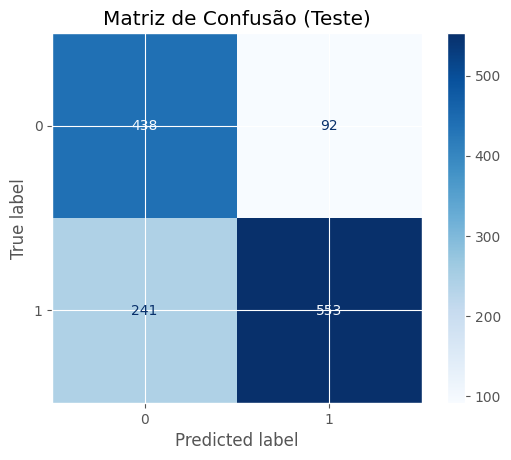

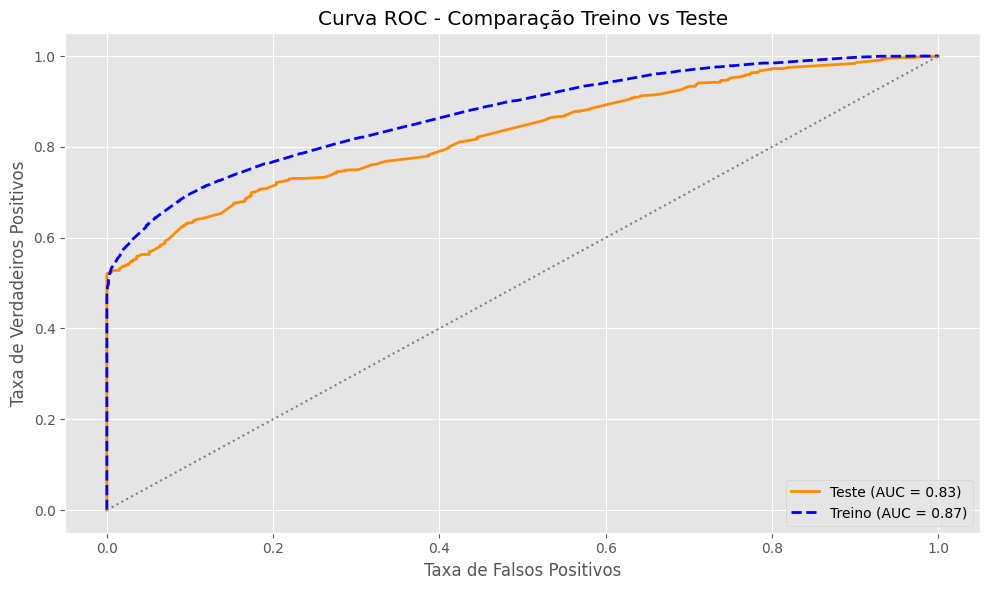

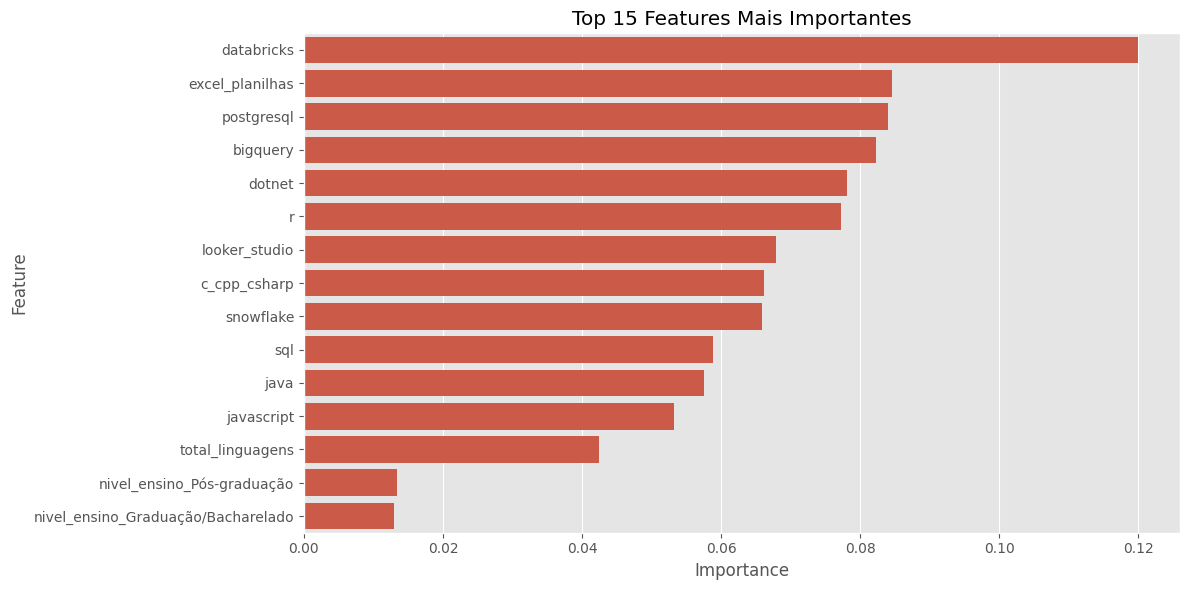

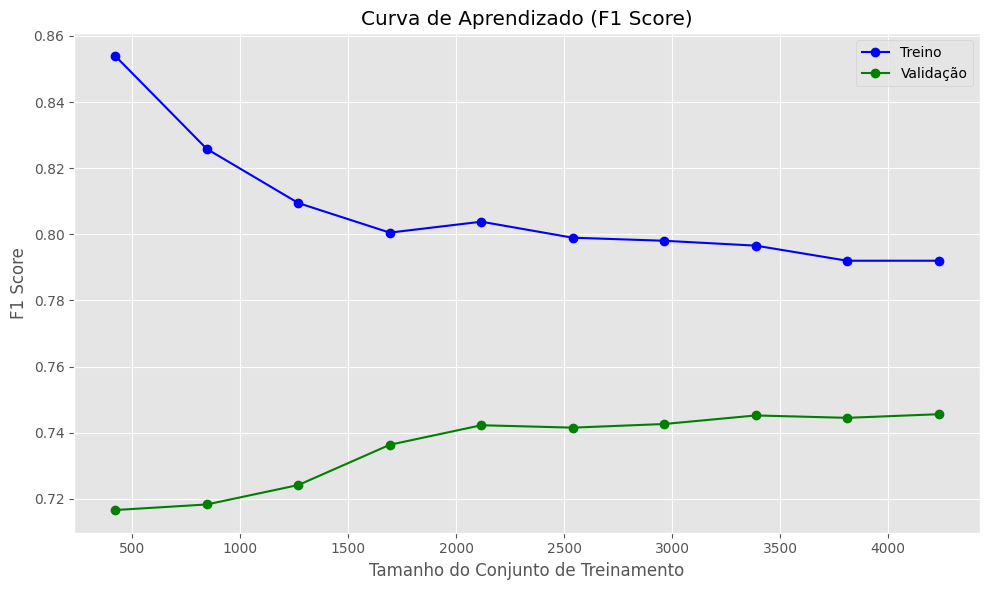

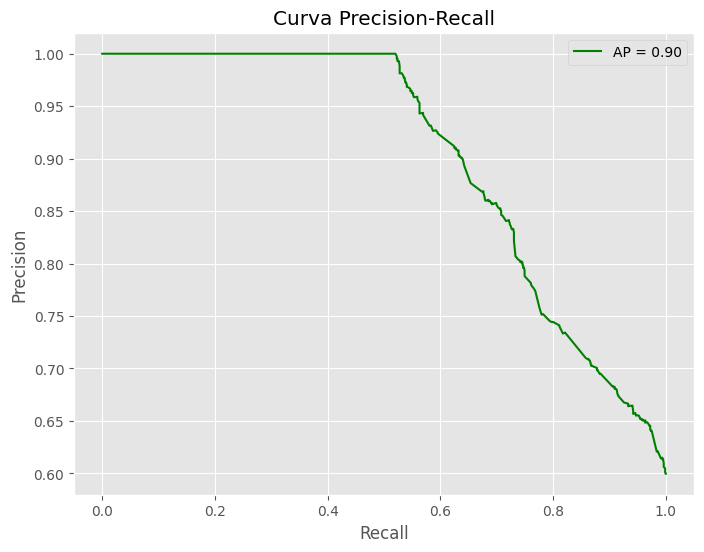

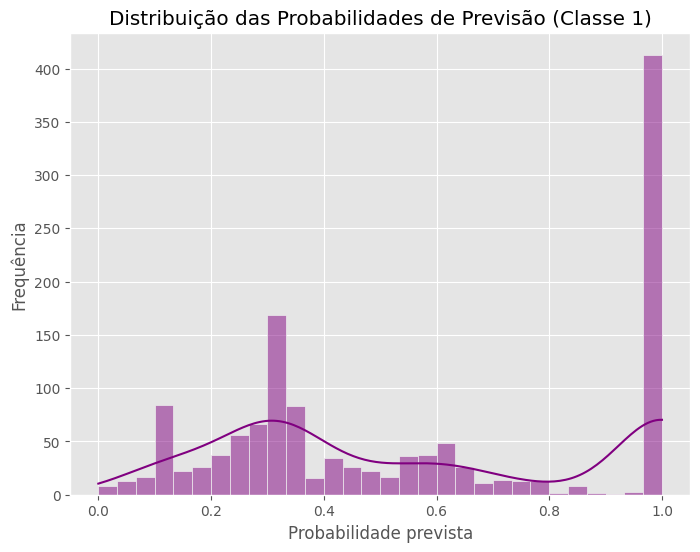

<Figure size 640x480 with 0 Axes>

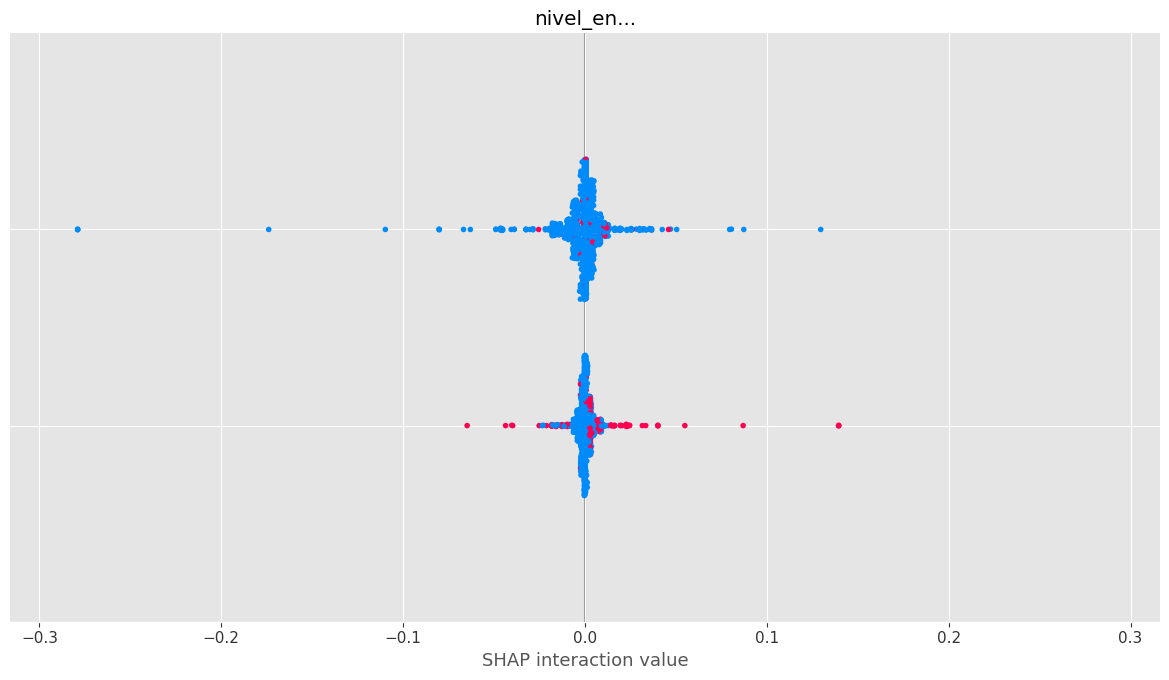

In [ ]:

import json
from sklearn.model_selection import learning_curve

# 6. Avaliação
best_model = grid_search.best_estimator_

# Previsões
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

# Probabilidades para curva ROC
y_proba_test = best_model.predict_proba(X_test)[:, 1]
y_proba_train = best_model.predict_proba(X_train)[:, 1]

# Acurácia
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print("\nMelhores parâmetros:", grid_search.best_params_)
print(f"Acurácia Treino: {acc_train:.2%}")
print(f"Acurácia Teste:  {acc_test:.2%}")

# Salvar parâmetros
with open("best_params.json", "w") as f:
    json.dump(grid_search.best_params_, f, indent=4)

# Relatório de Classificação
relatorio = classification_report(y_test, y_pred_test)
print("\nRelatório de Classificação (Teste):")
print(relatorio)

with open("classification_report.txt", "w") as f:
    f.write(relatorio)

# Matriz de Confusão
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title('Matriz de Confusão (Teste)')
plt.savefig("matriz_confusao.png", dpi=300)
plt.show()

# Curva ROC - Teste vs Treino
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Teste (AUC = {roc_auc_test:.2f})')
plt.plot(fpr_train, tpr_train, color='blue', lw=2, linestyle='--', label=f'Treino (AUC = {roc_auc_train:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle=':')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Comparação Treino vs Teste')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("curva_roc_comparativa.png", dpi=300)
plt.show()

# 7. Importância das Features
feature_names = (
    list(best_model.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(['nivel_ensino'])) +
    numeric_features
)

importances = best_model.named_steps['classifier'].feature_importances_
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Features Mais Importantes')
plt.tight_layout()
plt.savefig("importancia_features.png", dpi=300)
plt.show()

# 8. Curva de Aprendizado
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X, y,
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Treino')
plt.plot(train_sizes, val_scores_mean, 'o-', color='green', label='Validação')
plt.title('Curva de Aprendizado (F1 Score)')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.savefig("curva_aprendizado.png", dpi=300)
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_proba_test) # Use y_proba_test instead of y_proba
avg_precision = average_precision_score(y_test, y_proba_test) # Use y_proba_test instead of y_proba

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
sns.histplot(y_proba_test, bins=30, kde=True, color='purple') # Use y_proba_test instead of y_proba
plt.title('Distribuição das Probabilidades de Previsão (Classe 1)')
plt.xlabel('Probabilidade prevista')
plt.ylabel('Frequência')
plt.show()

# Preparar dados processados
X_transformed = best_model.named_steps['preprocessor'].transform(X_test)
explainer = shap.Explainer(best_model.named_steps['classifier'])
shap_values = explainer(X_transformed)

# Summary plot
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

## Mesmo Modelo mais sem limitação

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Melhores parâmetros: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_features': None, 'classifier__max_depth': 40, 'classifier__bootstrap': True}
Acurácia Treino: 84.86%
Acurácia Teste:  73.19%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       530
           1       0.81      0.72      0.76       794

    accuracy                           0.73      1324
   macro avg       0.73      0.73      0.73      1324
weighted avg       0.74      0.73      0.73      1324



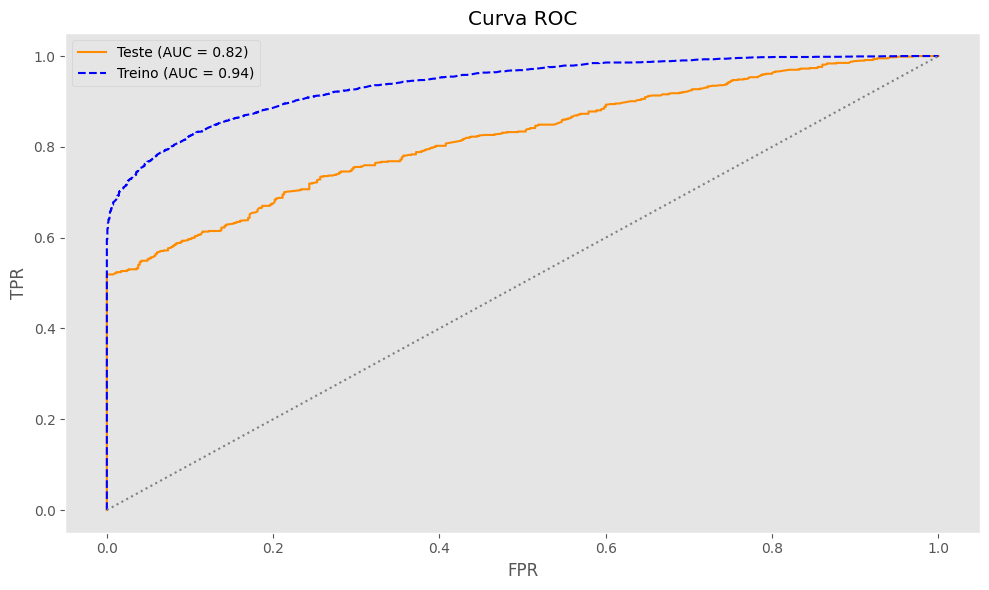

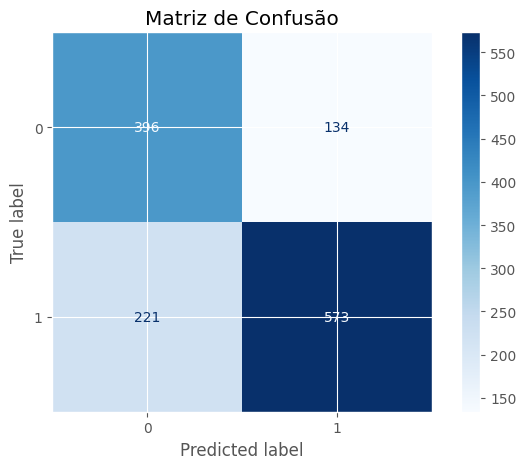

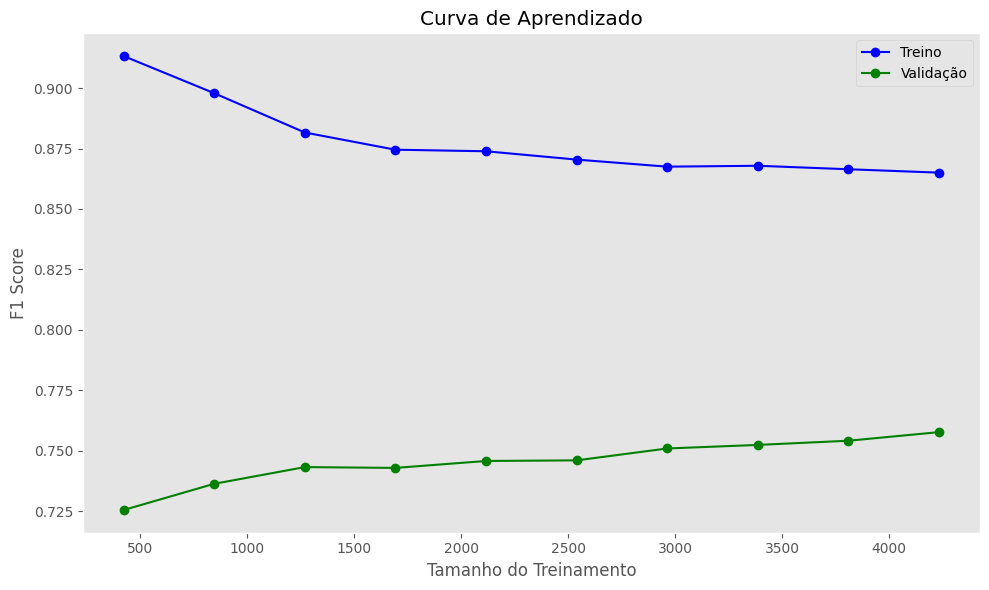

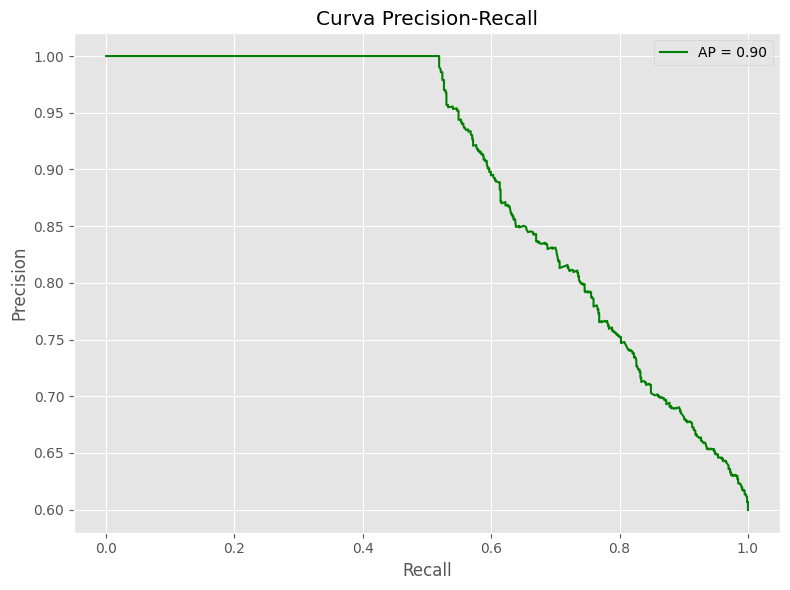

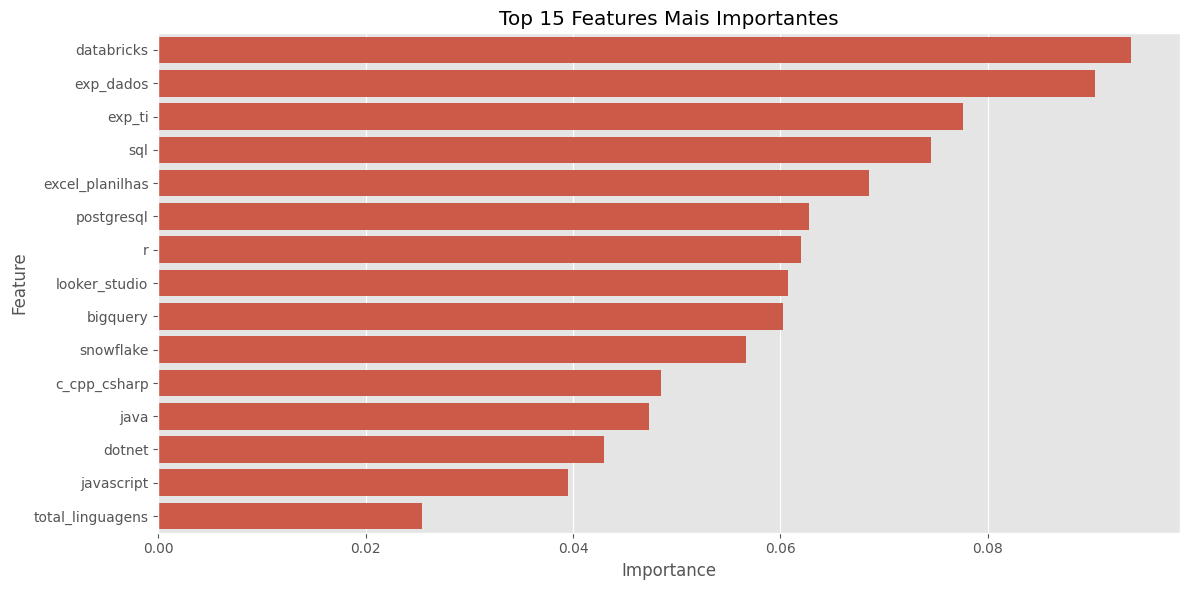

<Figure size 640x480 with 0 Axes>

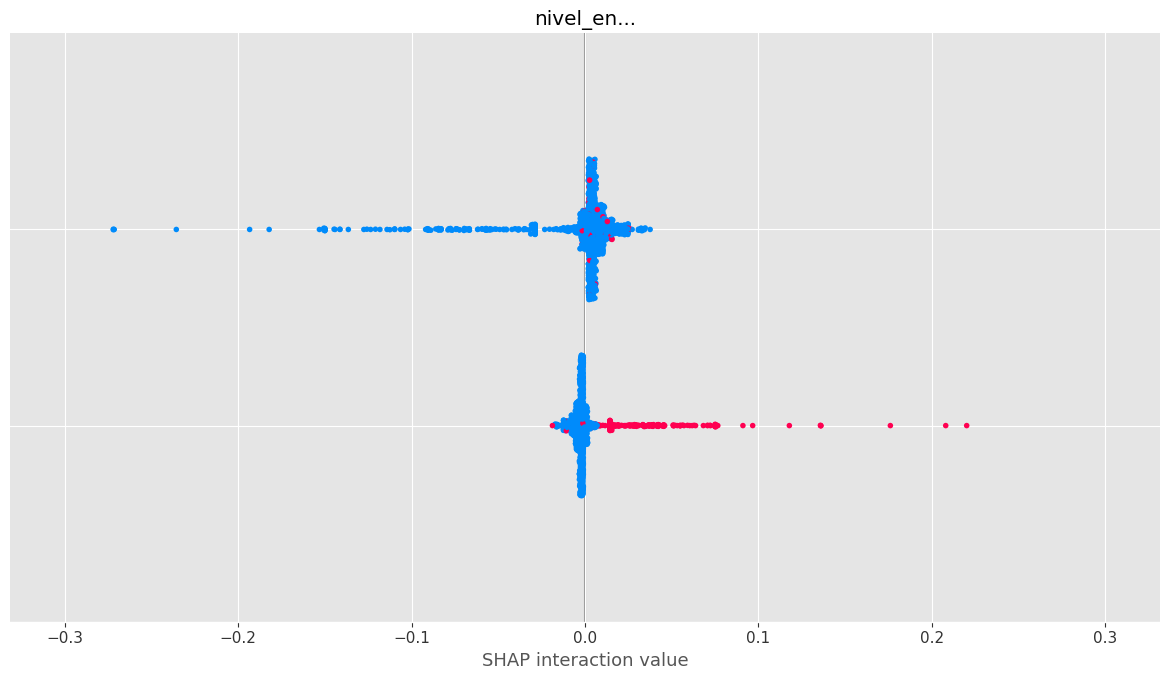

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import json

from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
from scipy.stats import randint

# Configurações gerais
pd.set_option('display.max_columns', 50)
plt.style.use('ggplot')

# Carregar dados
df = pd.read_csv('dados_selecionados.csv')

# Criar variável target
tech_cols = ['python', 'aws', 'azure', 'gcp', 'powerbi', 'tableau']
df[tech_cols] = df[tech_cols].astype(bool)
conditions = (
    df['python'] &
    (df['aws'] | df['azure'] | df['gcp']) &
    (df['powerbi'] | df['tableau'])
)
df['target_ia_generativa'] = np.where(conditions, 1, 0)

# Features seguras e engenharia
features_seguras = [
    'sql', 'r', 'c_cpp_csharp', 'dotnet', 'java', 'javascript',
    'postgresql', 'bigquery', 'snowflake', 'databricks',
    'looker_studio', 'excel_planilhas', 'exp_dados', 'exp_ti'
]
df['total_linguagens'] = df[['sql', 'r', 'c_cpp_csharp', 'java', 'javascript']].sum(axis=1)
df['exp_total'] = df['exp_dados'] + df['exp_ti']
features_seguras += ['total_linguagens', 'exp_total']

# Mapeamento de experiência
exp_map = {
    'Menos de 1 ano': 0.5,
    'de 1 a 2 anos': 1.5,
    'de 3 a 4 anos': 3.5,
    'de 5 a 6 anos': 5.5,
    'de 7 a 10 anos': 8.5,
    'Mais de 10 anos': 11
}
# Pré-processamento
numeric_features = features_seguras
# Convert categorical columns to numeric, exclude exp_dados and exp_ti
categorical_features = [col for col in features_seguras if df[col].dtype == 'object' and col not in ['exp_dados', 'exp_ti']]
for col in categorical_features:
    df[col] = df[col].map({'Sim': 1, 'Não': 0}).fillna(0).astype(int)

# Mapeamento de experiência - ensure these are numeric
df['exp_dados'] = pd.to_numeric(df['exp_dados'].astype(str).map(exp_map), errors='coerce').fillna(0)
df['exp_ti'] = pd.to_numeric(df['exp_ti'].astype(str).map(exp_map), errors='coerce').fillna(0)

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['nivel_ensino']),
    ('num', StandardScaler(), numeric_features)
], remainder='drop')

# Divisão dos dados
X = df[features_seguras + ['nivel_ensino']]
y = df['target_ia_generativa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=-1))
])

# Parâmetros para RandomizedSearchCV
params = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [None, 20, 40, 60],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}

# RandomizedSearchCV
search = RandomizedSearchCV(
    pipeline, params, n_iter=25, cv=5,
    scoring='f1', verbose=2, n_jobs=-1, random_state=42
)
search.fit(X_train, y_train)
best_model = search.best_estimator_

# Avaliação
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_proba_test = best_model.predict_proba(X_test)[:, 1]

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print("\nMelhores parâmetros:", search.best_params_)
print(f"Acurácia Treino: {acc_train:.2%}")
print(f"Acurácia Teste:  {acc_test:.2%}")

# Relatório
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_test))

# Curva ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Teste (AUC = {roc_auc_test:.2f})', color='darkorange')
plt.plot(fpr_train, tpr_train, label=f'Treino (AUC = {roc_auc_train:.2f})', color='blue', linestyle='--')
plt.plot([0, 1], [0, 1], color='gray', linestyle=':')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()

# Curva de Aprendizado
train_sizes, train_scores, val_scores = learning_curve(best_model, X, y, cv=5, scoring='f1',
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        n_jobs=-1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Treino', color='blue')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validação', color='green')
plt.xlabel('Tamanho do Treinamento')
plt.ylabel('F1 Score')
plt.title('Curva de Aprendizado')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
avg_precision = average_precision_score(y_test, y_proba_test)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.tight_layout()
plt.show()

# Importância das Features
feature_names = list(best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['nivel_ensino'])) + numeric_features
importances = best_model.named_steps['classifier'].feature_importances_
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances.head(15), x='Importance', y='Feature')
plt.title('Top 15 Features Mais Importantes')
plt.tight_layout()
plt.show()

# SHAP
X_transformed = best_model.named_steps['preprocessor'].transform(X_test)
explainer = shap.Explainer(best_model.named_steps['classifier'])
shap_values = explainer(X_transformed)
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)
